Latitude 10
10: campbell_norman clouds: dni: 722.18 dhi: 160.76 ghi: 882.95
Latitude 10
10: campbell_norman clouds: dni: 920.35 dhi: 101.32 ghi: 1021.66
OLD INTEGRAL: 953.3012413644543
NEW INTEGRAL: 943.8152481853274
SUM INTEGRAL: 94.38364272054432
Latitude 40
40: campbell_norman clouds: dni: 354.23 dhi: 141.35 ghi: 495.58
Latitude 40
40: campbell_norman clouds: dni: 512.65 dhi: 93.85 ghi: 606.50
OLD INTEGRAL: 565.5566469113998
NEW INTEGRAL: 559.8325968619897
SUM INTEGRAL: 55.983376562913314
Latitude 10
10: campbell_norman clouds: dni: 433.36 dhi: 247.41 ghi: 680.76
Latitude 10
10: campbell_norman clouds: dni: 920.35 dhi: 101.32 ghi: 1021.66
OLD INTEGRAL: 953.3012413644543
NEW INTEGRAL: 943.8152481853274
SUM INTEGRAL: 94.38364272054432
Latitude 40
40: campbell_norman clouds: dni: 162.61 dhi: 198.80 ghi: 361.42
Latitude 40
40: campbell_norman clouds: dni: 512.65 dhi: 93.85 ghi: 606.50
OLD INTEGRAL: 565.5566469113998
NEW INTEGRAL: 559.8325968619897
SUM INTEGRAL: 55.983376562913314


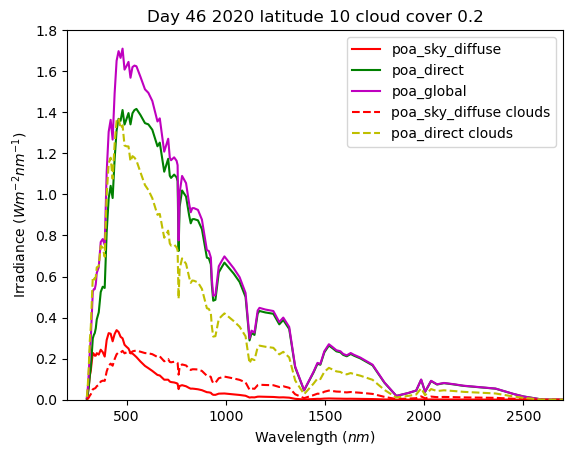

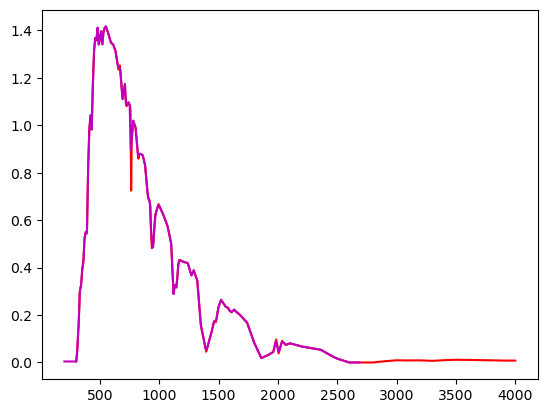

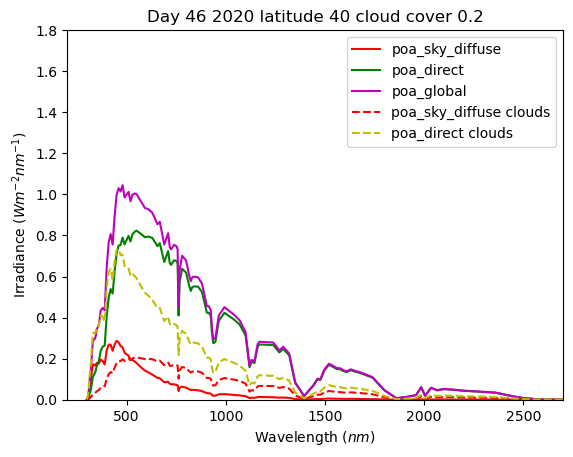

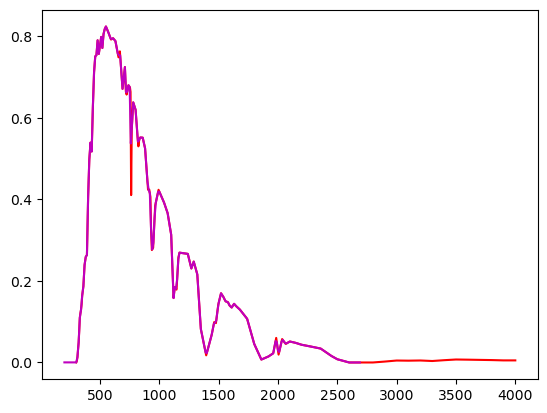

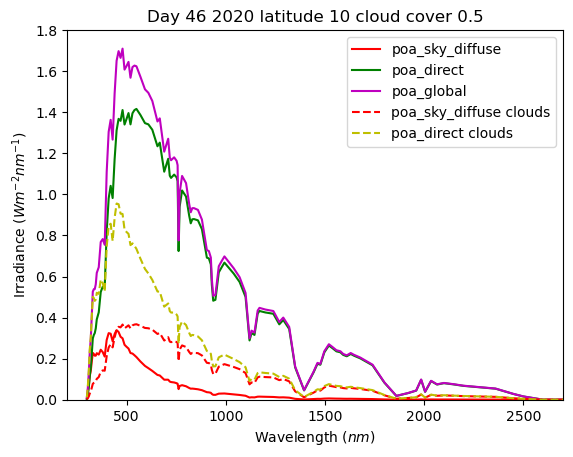

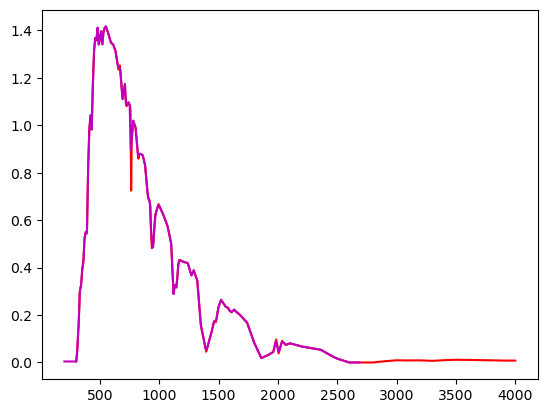

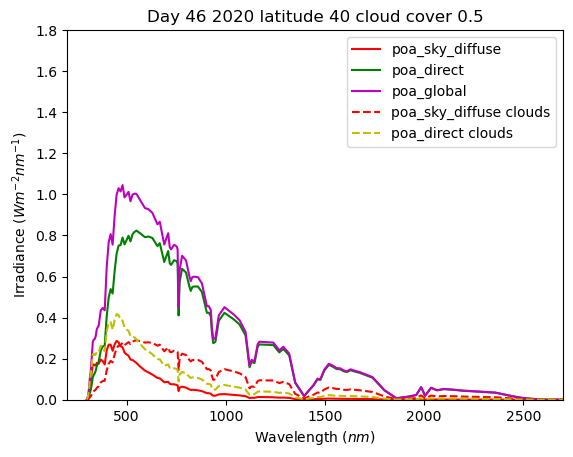

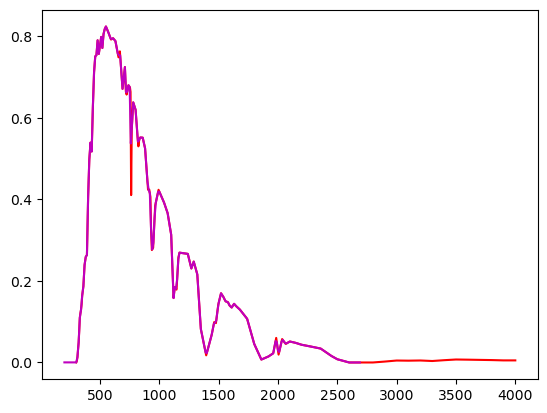

In [5]:
# Computational modules
import numpy as np
import pandas as pd
import pvlib
import datetime
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.style.use('default')

def setup_pv_system(month, hour_of_day):
    offset = 0  # int(lon_180/15.)
    when = [datetime.datetime(2020, month, 15, hour_of_day, 0, 0,
                              tzinfo=datetime.timezone(datetime.timedelta(hours=offset)))]
    time = pd.DatetimeIndex(when)

    sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
    sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

    module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
    inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
    pv_system = {'module': module, 'inverter': inverter,
                 'surface_azimuth': 180}

    return time, pv_system

def interpolate_to_standard_wavelengths(wavelengths_old, irrad):

    wavelengths = np.arange(200, 2700, 10)
    # Do the linear interpolation
    interp_irrad = np.interp(wavelengths, wavelengths_old, irrad[:,0])
    fig, ax = plt.subplots()
    print("OLD INTEGRAL: {}".format(np.trapz(x=wavelengths_old, y=irrad[:,0])))
    print("NEW INTEGRAL: {}".format(np.trapz(x=wavelengths, y=interp_irrad)))
    print("SUM INTEGRAL: {}".format(np.sum(interp_irrad)))

    ax.plot(wavelengths_old, irrad[:,0], c="r")
    ax.plot(wavelengths, interp_irrad, c="m")
    plt.show()

def plot_spectral_irradiance(spectra, F_dir, F_diff, latitude,  day_of_year, year, clouds=0.0):
    fig, ax = plt.subplots()
    ax.plot(spectra['wavelength'], spectra["poa_sky_diffuse"][:,0], c="r")
    ax.plot(spectra['wavelength'], spectra["poa_direct"][:,0], c="g")
    ax.plot(spectra['wavelength'], spectra["poa_global"][:,0], c="m")

    ax.plot(spectra['wavelength'], F_dir[:,0], c="r",linestyle='dashed')
    ax.plot(spectra['wavelength'], F_diff[:,0], c="y", linestyle='dashed')

    plt.xlim(200, 2700)
    plt.ylim(0, 1.8)
    plt.title(r"Day {} {} latitude {} cloud cover {}".format( day_of_year, year, latitude, clouds))
    plt.ylabel(r"Irradiance ($W m^{-2} nm^{-1}$)")
    plt.xlabel(r"Wavelength ($nm$)")
    labels = ["poa_sky_diffuse","poa_direct","poa_global","poa_sky_diffuse clouds","poa_direct clouds"]

    ax.legend(labels)
   # plt.savefig("spectral_test_{}.png".format(latitude))
    plt.show()

def show_info(latitude, irradiance):
    print("Latitude {}".format(latitude))
    print("{}: campbell_norman clouds: dni: {:3.2f} dhi: {:3.2f} ghi: {:3.2f}".format(latitude, float(irradiance['poa_direct']),
                                                     float(irradiance['poa_diffuse']),
                                                     float(irradiance['poa_global'])))


def cloud_opacity_factor(I_diff_clouds, I_dir_clouds, I_ghi_clouds, spectra):
    # First we calculate the rho fraction based on campbell_norman irradiance
    # with clouds converted to POA irradiance. In the paper these
    # values are obtained from observations. The equations used for calculating cloud opacity factor
    # to scale the clear sky spectral estimates using spectrl2. Results can be compared with sun calculator:
    # https://www2.pvlighthouse.com.au/calculators/solar%20spectrum%20calculator/solar%20spectrum%20calculator.aspx
    #
    # Ref: Marco Ernst, Hendrik Holst, Matthias Winter, Pietro P. Altermatt,
    # SunCalculator: A program to calculate the angular and spectral distribution of direct and diffuse solar radiation,
    # Solar Energy Materials and Solar Cells, Volume 157, 2016, Pages 913-922,

    rho = I_diff_clouds/I_ghi_clouds

    I_diff_s = np.trapz(y=spectra['poa_sky_diffuse'][:,0], x=spectra['wavelength'])
    I_dir_s = np.trapz(y=spectra['poa_direct'][:,0], x=spectra['wavelength'])
    I_glob_s = np.trapz(y=spectra['poa_global'][:,0], x=spectra['wavelength'])

    rho_spectra = I_diff_s/I_glob_s

    N_rho = (rho-rho_spectra)/(1-rho_spectra)

    # Direct light. Equation 6 Ernst et al. 2016
    F_diff_s = spectra['poa_sky_diffuse'][:,:]
    F_dir_s = spectra['poa_direct'][:,:]

    F_dir = (F_dir_s/I_dir_s) * I_dir_clouds

    # Diffuse light scaling factor. Equation 7 Ernst et al. 2016
    s_diff = (1 - N_rho) *(F_diff_s/I_diff_s) + N_rho*((F_dir_s + F_diff_s)/I_glob_s)

    # Equation 8 Ernst et al. 2016
    F_diff = s_diff * I_diff_clouds

    return F_dir, F_diff

month=2
hour_of_day=12

ctime, pv_system = setup_pv_system(month, hour_of_day)
altitude = 0.0
latitudes=[10,40]
cloud_covers=[0.2, 0.5]

for cloud_cover in cloud_covers:
    for latitude in latitudes:
        longitude = 0.0
        solpos = pvlib.solarposition.get_solarposition(ctime, latitude, longitude)

        airmass_relative = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'].to_numpy(),
                                                                 model='kastenyoung1989')
        pressure = pvlib.atmosphere.alt2pres(altitude)
        airmass_abs = pvlib.atmosphere.get_absolute_airmass(airmass_relative, pressure)

        apparent_zenith = solpos['apparent_zenith'].to_numpy()
        azimuth = solpos['azimuth'].to_numpy()

        surface_tilt = 0.0# latitude #latitude
        surface_azimuth = pv_system['surface_azimuth']

        # cloud cover in fraction units here
        transmittance = (1.0 - cloud_cover) * 0.75
        aoi = pvlib.irradiance.aoi(surface_tilt, surface_azimuth, apparent_zenith, azimuth)

        water_vapor_content = 0.5
        tau500 = 0.1
        ground_albedo = 0.06
        ozone = 0.3

        # day of year is an int64index array so access first item
        day_of_year = ctime.dayofyear[0]

        spectra = pvlib.spectrum.spectrl2(
            apparent_zenith=apparent_zenith,
            aoi=aoi,
            surface_tilt=surface_tilt,
            ground_albedo=ground_albedo,
            surface_pressure=pressure,
            relative_airmass=airmass_relative,
            precipitable_water=water_vapor_content,
            ozone=ozone,
            aerosol_turbidity_500nm=tau500,
            dayofyear=day_of_year)

        irrads_clouds = pvlib.irradiance.campbell_norman(solpos['zenith'].to_numpy(), transmittance)

        # Convert the irradiance to a plane with tilt zero horizontal to the earth. This is done applying tilt=0 to POA
        # calculations using the output from campbell_norman. The POA calculations include calculting sky and ground
        # diffuse light where specific models can be selected (we use default)
        POA_irradiance_clouds = pvlib.irradiance.get_total_irradiance(
            surface_tilt=surface_tilt,
            surface_azimuth=pv_system['surface_azimuth'],
            dni=irrads_clouds['dni'],
            ghi=irrads_clouds['ghi'],
            dhi=irrads_clouds['dhi'],
            solar_zenith=solpos['apparent_zenith'],
            solar_azimuth=solpos['azimuth'])

        show_info(latitude, POA_irradiance_clouds)

        irrads_clearsky = pvlib.irradiance.campbell_norman(solpos['zenith'].to_numpy(), transmittance=0.75)

        POA_irradiance_clearsky = pvlib.irradiance.get_total_irradiance(
            surface_tilt=surface_tilt,
            surface_azimuth=pv_system['surface_azimuth'],
            dni=irrads_clearsky['dni'],
            ghi=irrads_clearsky['ghi'],
            dhi=irrads_clearsky['dhi'],
            solar_zenith=solpos['apparent_zenith'],
            solar_azimuth=solpos['azimuth'])

        show_info(latitude, POA_irradiance_clearsky)

        F_dir, F_diff = cloud_opacity_factor(POA_irradiance_clouds['poa_direct'].values,
                                             POA_irradiance_clouds['poa_diffuse'].values,
                                             POA_irradiance_clouds['poa_global'].values,
                                             spectra)

        plot_spectral_irradiance(spectra,
                                 F_dir,
                                 F_diff,
                                 latitude=latitude,
                                 day_of_year=day_of_year,
                                 year=ctime.year[0],
                                 clouds=cloud_cover)

        interpolate_to_standard_wavelengths(spectra["wavelength"], spectra["poa_direct"])
    #%%